# 🧠 Brain Tumor 3D [Training]

## ☀️ Importing Libraries

In [1]:
import os
import sys 
import json
import glob
import random
import collections
import time
import re
import math
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

from random import shuffle
from sklearn import model_selection as sk_model_selection

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.metrics import AUC

import tensorflow as tf

# Loading Data

In [2]:
data_directory = '../input/rsna-miccai-brain-tumor-radiogenomic-classification'
pytorch3dpath = "../input/efficientnetpyttorch3d/EfficientNet-PyTorch-3D"
 
mri_types = ['FLAIR','T1w','T1wCE','T2w']
mri_types_id=0 # 0,1,2,3

IMAGE_SIZE = 256
NUM_IMAGES = 64
BATCH_SIZE= 4

num_folds=5
Selected_fold=1 #1,2,3,4,5 

train_df = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")
train_df['BraTS21ID5'] = [format(x, '05d') for x in train_df.BraTS21ID]
train_df["Fold"]="train"
train_df.head(5)

# For debug
#train_df=train_df.head(n=40)

,BraTS21ID,MGMT_value,BraTS21ID5,Fold
0,0,1,00000,train
1,2,1,00002,train
2,3,0,00003,train
3,5,1,00005,train
4,6,1,00006,train


In [3]:
sample_submission = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv')
test=sample_submission
test['BraTS21ID5'] = [format(x, '05d') for x in test.BraTS21ID]
test.head(3)

,BraTS21ID,MGMT_value,BraTS21ID5
0,1,0.5,00001
1,13,0.5,00013
2,15,0.5,00015


# Functions to load images


(1, 256, 256, 64)
0.0 1.0 0.07902179328632788 0.00023671822699371212
Dimension of the CT scan is: (256, 256, 64)


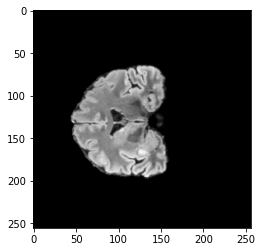

In [4]:
def load_dicom_image(path, img_size=IMAGE_SIZE, voi_lut=True, rotate=0):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
        
    if rotate > 0:
        rot_choices = [0, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
        data = cv2.rotate(data, rot_choices[rotate])
        
    data = cv2.resize(data, (img_size, img_size))
    return data


def load_dicom_images_3d(scan_id, num_imgs=NUM_IMAGES, img_size=IMAGE_SIZE, mri_type=mri_types[mri_types_id], split="train", rotate=0):

    files = sorted(glob.glob(f"{data_directory}/{split}/{scan_id}/{mri_type}/*.dcm"), 
               key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])

    middle = len(files)//2
    num_imgs2 = num_imgs//2
    p1 = max(0, middle - num_imgs2)
    p2 = min(len(files), middle + num_imgs2)
    img3d = np.stack([load_dicom_image(f, rotate=rotate) for f in files[p1:p2]]).T 
    if img3d.shape[-1] < num_imgs:
        n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
        img3d = np.concatenate((img3d,  n_zero), axis = -1)
        
    if np.min(img3d) < np.max(img3d):
        img3d = img3d - np.min(img3d)
        img3d = img3d / np.max(img3d)
            
    return np.expand_dims(img3d,0)

a = load_dicom_images_3d("00000")
print(a.shape)
print(np.min(a), np.max(a), np.mean(a), np.median(a))
image = a[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 31]), cmap="gray")

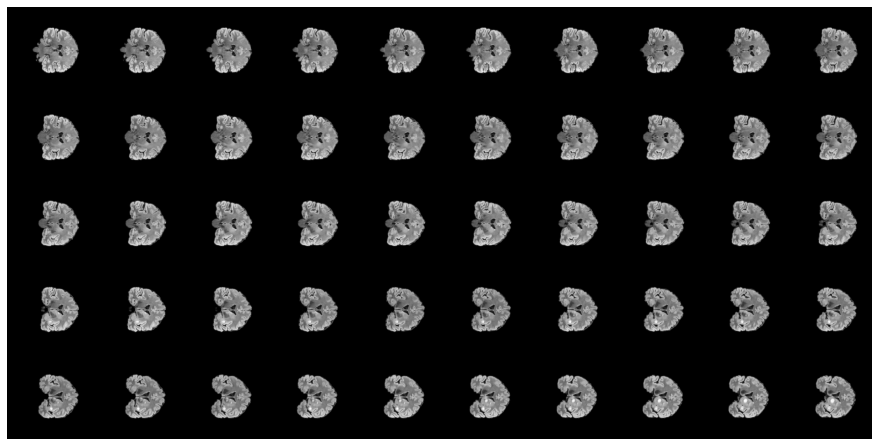

In [5]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))  
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()
# Visualize montage of slices.
# 5 rows and 10 columns for 100 slices of the CT scan.
plot_slices(5, 10, IMAGE_SIZE, IMAGE_SIZE, image[:, :, :50])

# Folds

In [6]:
from sklearn.model_selection import KFold,StratifiedKFold
sfolder = StratifiedKFold(n_splits=5,random_state=13,shuffle=True)
X = train_df[['BraTS21ID']]
y = train_df[['MGMT_value']]

fold_no = 1
for train, valid in sfolder.split(X,y):
    if fold_no==Selected_fold:
        train_df.loc[valid, "Fold"] = "valid"
    fold_no += 1

In [7]:
df_train=train_df[train_df.Fold=="train"]
df_valid=train_df[train_df.Fold=="valid"]
print("df_train=",len(df_train),"-- df_valid=",len(df_valid))

df_train= 468 -- df_valid= 117


#  Custom Data Generator

In [8]:
from keras.utils import Sequence
class Dataset(Sequence):
    def __init__(self,df,is_train=True,batch_size=BATCH_SIZE,shuffle=True):
        self.idx = df["BraTS21ID"].values
        self.paths = df["BraTS21ID5"].values
        self.y =  df["MGMT_value"].values
        self.is_train = is_train
        self.batch_size = batch_size
        self.shuffle = shuffle
    def __len__(self):
        return math.ceil(len(self.idx)/self.batch_size)
   
    def __getitem__(self,ids):
        id_path= self.paths[ids]
        batch_paths = self.paths[ids * self.batch_size:(ids + 1) * self.batch_size]
        
        if self.y is not None:
            batch_y = self.y[ids * self.batch_size: (ids + 1) * self.batch_size]
        
        if self.is_train:
            list_x =  [load_dicom_images_3d(x,split="train") for x in batch_paths]
            batch_X = np.stack(list_x, axis=4)
            return batch_X,batch_y
        else:
            list_x =  load_dicom_images_3d(id_path,split="test")#str(scan_id).zfill(5)
            batch_X = np.stack(list_x)
            return batch_X
    
    def on_epoch_end(self):
        if self.shuffle and self.is_train:
            ids_y = list(zip(self.idx, self.y))
            shuffle(ids_y)
            self.idx, self.y = list(zip(*ids_y))


In [9]:
train_dataset = Dataset(df_train,batch_size=BATCH_SIZE)
valid_dataset = Dataset(df_valid,batch_size=BATCH_SIZE)

Dimension of the CT scan is: (1, 256, 256, 64, 4)
label= [1 1 0 1]


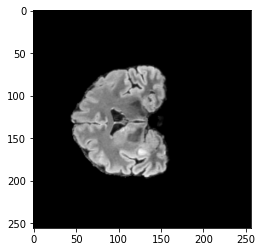

In [10]:
for i in range(1):
    images, label = train_dataset[i]
    print("Dimension of the CT scan is:", images.shape)
    print("label=",label)
    plt.imshow(images[0,:,:,32,0], cmap="gray")
    plt.show()

# Model

In [11]:
def get_model(width=IMAGE_SIZE, height=IMAGE_SIZE, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))
     
    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.01)(x)
    
    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.02)(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.03)(x)

    x = layers.Conv3D(filters=512, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.04)(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=1024, activation="relu")(x)
    x = layers.Dropout(0.08)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")

    return model

# Build model.
model = get_model(width=IMAGE_SIZE, height=IMAGE_SIZE, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 64, 1)] 0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 254, 254, 62, 64)  1792      
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 127, 127, 31, 64)  0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 127, 127, 31, 64)  256       
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 31, 64)  0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 125, 125, 29, 128) 221312    
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 62, 62, 14, 128)   0     

# Training

In [12]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=[AUC(name='auc'),"acc"],
)
# Define callbacks.
model_save = ModelCheckpoint(f'Brain_3d_cls_{mri_types[mri_types_id]}_Fold_{Selected_fold}.h5', 
                             save_best_only = True, 
                             monitor = 'val_auc', 
                             mode = 'max', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_auc', 
                           patience = 10, mode = 'max', verbose = 1,
                           restore_best_weights = True)

# Train the model, doing validation at the end of each epoch
epochs = 50
model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=1,
    callbacks = [model_save, early_stop],
)

Epoch 1/50
117/117 [==============================] - 394s 3s/step - loss: 0.6935 - auc: 0.4533 - acc: 0.4677 - val_loss: 0.7883 - val_auc: 0.4626 - val_acc: 0.4701

Epoch 00001: val_auc improved from -inf to 0.46261, saving model to Brain_3d_cls_FLAIR_Fold_1.h5
Epoch 2/50
117/117 [==============================] - 311s 3s/step - loss: 0.6915 - auc: 0.4491 - acc: 0.5648 - val_loss: 0.8219 - val_auc: 0.5326 - val_acc: 0.4701

Epoch 00002: val_auc improved from 0.46261 to 0.53255, saving model to Brain_3d_cls_FLAIR_Fold_1.h5
Epoch 3/50
117/117 [==============================] - 305s 3s/step - loss: 0.6921 - auc: 0.5281 - acc: 0.5290 - val_loss: 0.8073 - val_auc: 0.4540 - val_acc: 0.4701

Epoch 00003: val_auc did not improve from 0.53255
Epoch 4/50
117/117 [==============================] - 303s 3s/step - loss: 0.6933 - auc: 0.4730 - acc: 0.5077 - val_loss: 0.8458 - val_auc: 0.4787 - val_acc: 0.4786

Epoch 00004: val_auc did not improve from 0.53255
Epoch 5/50
117/117 [===================

# Visualizing model performance

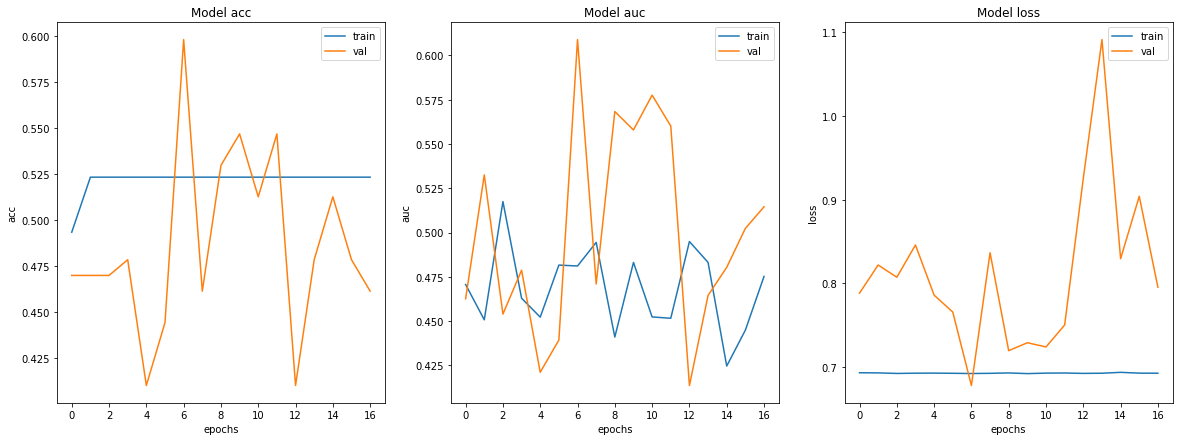

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(20, 7))
ax = ax.ravel()

for i, metric in enumerate(["acc","auc","loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

# Make predictions

Dimension of the CT scan is: (1, 256, 256, 64)


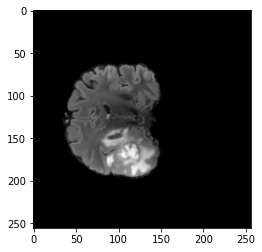

In [14]:
test_dataset = Dataset(test,is_train=False,batch_size=1)


for i in range(1):
    image = test_dataset[i]
    print("Dimension of the CT scan is:", image.shape)
    plt.imshow(image[0,:,:, 32], cmap="gray")
    plt.show()

In [15]:
preds = model.predict(test_dataset)
preds = preds.reshape(-1)

In [16]:
preds

array([0.32175645, 0.32603404, 0.29367563, 0.3010953 , 0.31999406,
       0.3122343 , 0.3285949 , 0.31311107, 0.30650517, 0.30779958,
       0.24571106, 0.43472075, 0.3902089 , 0.7765539 , 0.38995665,
       0.8213614 , 0.35787216, 0.5212586 , 0.5641759 , 0.4113071 ,
       0.46772513, 0.48592985, 0.4720498 , 0.48580912, 0.47692195,
       0.2882278 , 0.29265097, 0.507039  , 0.56482565, 0.49782002,
       0.41857424, 0.43542922, 0.5674293 , 0.4726061 , 0.36164978,
       0.5134792 , 0.43110007, 0.43129808, 0.49275374, 0.4720484 ,
       0.45212013, 0.72049683, 0.43441236, 0.5139746 , 0.47926742,
       0.8600191 , 0.75965834, 0.8454484 , 0.87447846, 0.3161837 ,
       0.3227957 , 0.36005378, 0.3177917 , 0.30922619, 0.32307327,
       0.39898667, 0.37824658, 0.2952544 , 0.3318121 , 0.28525436,
       0.2628639 , 0.7485296 , 0.33515105, 0.380252  , 0.3275264 ,
       0.35603508, 0.3437267 , 0.32705536, 0.3201538 , 0.32910052,
       0.29113448, 0.3178636 , 0.30344695, 0.34557983, 0.33723

In [17]:
submission = pd.DataFrame({'BraTS21ID':sample_submission['BraTS21ID'],'MGMT_value':preds})
submission

,BraTS21ID,MGMT_value
0,1,0.321756
1,13,0.326034
2,15,0.293676
3,27,0.301095
4,37,0.319994
...,...,...
82,826,0.575152
83,829,0.303548
84,833,0.432618
85,997,0.764801


In [18]:
submission.to_csv('submission.csv',index=False)

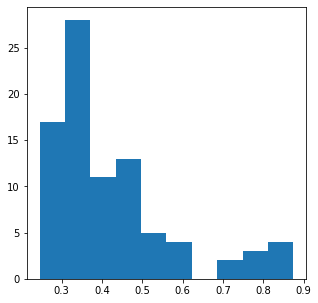

In [19]:
plt.figure(figsize=(5, 5))
plt.hist(submission["MGMT_value"]);